In [1]:
%matplotlib inline
import pylab
import pandas as pd

## load mapping summary CSVs and gather CSV

In [2]:
sample_id = 'SRR606249'

# load mapping CSVs
all_df = pd.read_csv(f'outputs/minimap/depth/{sample_id}.summary.csv')
left_df = pd.read_csv(f'outputs/leftover/depth/{sample_id}.summary.csv')

# load gather CSV
gather_df = pd.read_csv(f'outputs/{sample_id}.gather.csv')

# connect gather_df to all_df and left_df using 'genome_id'
def fix_name(x):
    return "_".join(x.split('_')[:2]).split('.')[0]

gather_df['genome_id'] = gather_df['name'].apply(fix_name)

In [3]:
# re-sort left_df and all_df to match gather_df order, using matching genome_id column
all_df.set_index("genome_id")
all_df.reindex(index=gather_df["genome_id"])
all_df.reset_index()
all_df[:3]

left_df.set_index("genome_id")
left_df.reindex(index=gather_df["genome_id"])
left_df.reset_index()
left_df[:3]

left_df["mapped_bp"] = (1 - left_df["percent missed"]/100) * left_df["genome bp"]

In [4]:
left_df[:5]

,Unnamed: 0,genome bp,missed,percent missed,coverage,genome_id,sample_id,mapped_bp
0,GCA_000013645,9731138,70330,0.722732,10.224036,GCA_000013645,SRR606249,9660808.0
1,GCA_000009705,7211789,174,0.002413,33.737305,GCA_000009705,SRR606249,7211615.0
2,GCA_000196115,7145576,104,0.001455,134.405926,GCA_000196115,SRR606249,7145472.0
3,GCA_000018565,6785430,631,0.009299,23.436817,GCA_000018565,SRR606249,6784799.0
4,GCA_002959695,6481410,13840,0.213534,24.524634,GCA_002959695,SRR606249,6467570.0


In [5]:
gather_df[:5]

,intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,md5,f_match_orig,unique_intersect_bp,gather_result_rank,remaining_bp,genome_id
0,9323000,0.024885,0.977254,0.024885,0.008649,6.831814,6.0,5.847358,GCA_000013645.1_ASM1364v1_genomic.fna.gz,all-gather-genomes.sbt.zip,ee9cb05018009af43429e83e7d502a0a,0.977254,9323000,0,365320000,GCA_000013645
1,7288000,0.019453,0.999040,0.019453,0.023517,23.763035,18.0,29.637611,GCA_000009705.1_ASM970v1_genomic.fna.gz,all-gather-genomes.sbt.zip,264cfdad44548ad96c4a24b6a514a877,0.999040,7288000,1,358032000,GCA_000009705
2,7039000,0.018789,0.999858,0.018789,0.089562,93.700242,92.0,27.877040,GCA_000196115.1_ASM19611v1_genomic.fna.gz,all-gather-genomes.sbt.zip,7141c3fbf206734950d13cadba0bf46c,0.999858,7039000,2,350993000,GCA_000196115
3,6604000,0.017627,0.999697,0.017627,0.014621,16.304058,16.0,6.636986,GCA_000018565.1_ASM1856v1_genomic.fna.gz,all-gather-genomes.sbt.zip,5165e0f27ae96c8a78da00c2d30a8e36,0.999697,6604000,3,344389000,GCA_000018565
4,6323000,0.016877,0.997948,0.016877,0.014897,17.349676,17.0,8.548490,GCA_002959695.1_ASM295969v1_genomic.fna.gz,all-gather-genomes.sbt.zip,cefca2cf1f2ffaacdd22d23b45bfb6cb,0.997948,6323000,4,338066000,GCA_002959695


## fig 1: examining leftover reads, in order of gather

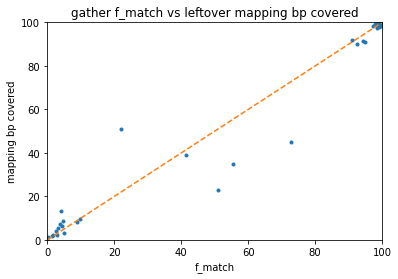

In [6]:
pylab.plot(gather_df["f_match"]* 100, 100 - left_df["percent missed"], '.')
pylab.xlim(0, 100)
pylab.ylim(0, 100)
pylab.xlabel('f_match')
pylab.ylabel('mapping bp covered')
pylab.title('gather f_match vs leftover mapping bp covered')
pylab.plot([0, 100], [0, 100], '--')

## fig 2: fraction of hashes unique to query, in order of gather results

Text(0, 0.5, 'f_unique_to_query, as %')

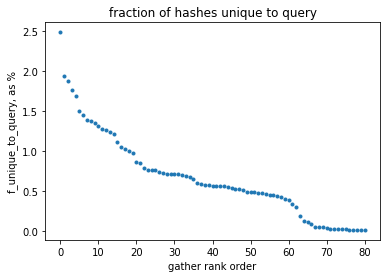

In [7]:
pylab.plot(gather_df.index, gather_df["f_unique_to_query"]*100, '.')
pylab.title('fraction of hashes unique to query')
pylab.xlabel('gather rank order')
pylab.ylabel('f_unique_to_query, as %')

## fig 4: sum mapped bp and sum identified hashes, in order of gather

conclusion: across the gather run, total hashes identified correlate well with total bp mapped

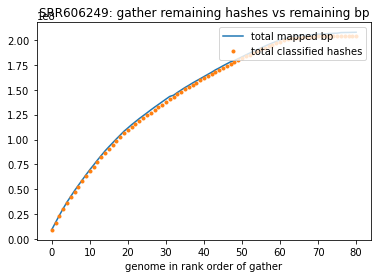

In [8]:
pylab.plot(left_df.index, left_df["mapped_bp"].cumsum(), '-', label='total mapped bp')
pylab.plot(gather_df.index, gather_df["unique_intersect_bp"].cumsum(), '.', label='total classified hashes')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather remaining hashes vs remaining bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')

## fig 5: mapped bp and identified hashes compared by sample, in order of gather

conclusion: for most samples, bp mapped to that genome matches # of hashes classified to that genome

note: hashes classified to this genome is monotonically decreasing, b/c gather is a greedy algorithm.

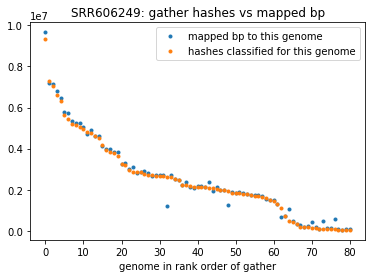

In [9]:
pylab.plot(left_df.index, left_df.mapped_bp, '.', label='mapped bp to this genome')
pylab.plot(gather_df.index, gather_df.unique_intersect_bp, '.', label='hashes classified for this genome')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')

## fig 6: difference between hashes ident and bp mapped

Text(0, 0.5, 'difference: hashcount - mapped bp')

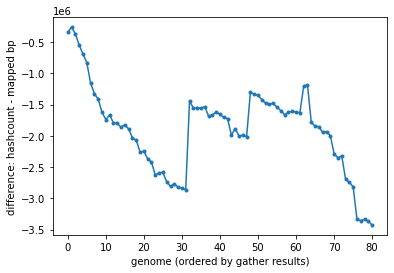

In [10]:
pylab.plot(gather_df.index, gather_df.unique_intersect_bp.cumsum() - left_df.mapped_bp.cumsum(), '.-')
pylab.xlabel('genome (ordered by gather results)')
pylab.ylabel('difference: hashcount - mapped bp')

## fig 7: difference between hashes and bp, per sample

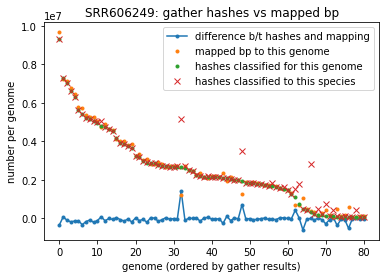

In [12]:
pylab.plot(gather_df.index, gather_df.unique_intersect_bp - left_df.mapped_bp, '.-', label='difference b/t hashes and mapping')

pylab.plot(left_df.index, left_df.mapped_bp, '.', label='mapped bp to this genome')
pylab.plot(gather_df.index, gather_df.unique_intersect_bp, '.', label='hashes classified for this genome')
pylab.plot(gather_df.index, gather_df.intersect_bp, 'x', label='hashes classified to this species')


pylab.xlabel('genome (ordered by gather results)')
#pylab.ylabel('difference: hashcount - mapped bp')
pylab.ylabel('number per genome')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')
pylab.savefig(f'/tmp/gather-{sample_id}.svg')